# Análise de dados

In [105]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pytz
import pandas as pd

try:
    sc = SparkContext('local[*]')
    sc.setLogLevel("OFF")
    
except ValueError:
    # Prevent the notebook to crash if this block is executed more then once
    pass

spark = SparkSession(sc)

In [2]:
wifi   = spark.read.parquet("./data/ds/wifi-log.parquet")
gps    = spark.read.parquet("./data/ds/gps-log.parquet")
oui    = spark.read.parquet("./data/ds/oui.parquet")
survey = spark.read.parquet("./data/ds/survey.parquet")

In [3]:
survey.groupBy("date").count().withColumn("day", date_format("date", "EEEE")).toPandas()

,date,count,day
0,2017-12-08,46,Friday
1,2017-12-06,46,Wednesday
2,2017-12-13,33,Wednesday
3,2017-11-29,38,Wednesday
4,2017-12-07,43,Thursday
5,2017-12-11,36,Monday
6,2017-12-12,36,Tuesday


In [4]:
phones = wifi.join(oui.dropDuplicates(["prefix"]), substring("mac", 0, 8) == col("prefix"))
makers = phones.groupBy("maker").count().orderBy(desc("count"))

wifi_total = wifi.count()
phones_total = phones.count()

totals = spark.createDataFrame([
    ("Celulares", phones_total, "%.2f%%" % (phones_total / wifi_total * 100)),
    ("Total",  wifi_total, "100%")
], ["", "count", "P"])
totals.toPandas()

,,count,P
0,Celulares,721846,79.57%
1,Total,907168,100%


In [5]:
to_percentage = lambda col_name, total: format_string("%.2f%%", col(col_name) / total * 100)

makers = makers.withColumn("share", to_percentage("count", phones_total))
makers.toPandas().head()

,maker,count,share
0,Samsung,258449,35.80%
1,Motorola,201424,27.90%
2,Lenovo,155135,21.49%
3,LG,47524,6.58%
4,Apple,27201,3.77%


In [6]:
from operator import add

OTHERS_THRESHOLD = 7000

count = makers.filter(col("count") < OTHERS_THRESHOLD).rdd.map(lambda x: x["count"]).reduce(add)
share = "%.2f%%" % (count / phones_total * 100)

others = spark.createDataFrame([("Outros", count, share)], ["maker", "count", "share"])
others.toPandas()

,maker,count,share
0,Outros,9125,1.26%


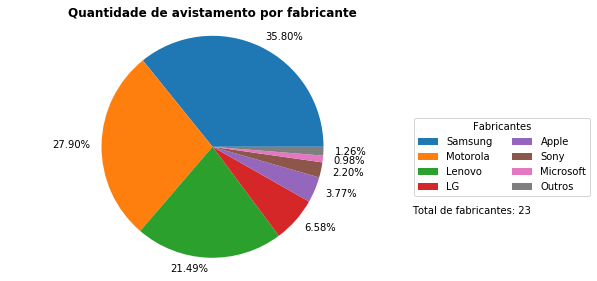

In [485]:
m = makers.filter(col("count") > OTHERS_THRESHOLD).unionAll(others).toPandas()

# 'tab20', 'tab20b', 'tab20c'
# patches.set_cmap("tab20b")

patches, texts = plt.pie(m['count'], labels=m['share'], startangle=0)
plt.title("Quantidade de avistamento por fabricante", {'fontweight':'bold'})
plt.text(1.8, -0.6, "Total de fabricantes: %d" % makers.count())
plt.legend(patches, m['maker'], ncol=2, loc=(1, 0.3), title="Fabricantes")
plt.axis('equal')
plt.tight_layout()

In [387]:
phones_ds = (
    phones
    .withColumn("date", date_format("timestamp", "dd/MM/yyyy"))
    .withColumn("timestamp", to_utc_timestamp(regexp_replace("timestamp", ",", "."), "UTC"))
    .drop("level", "organization", "prefix")
)
phones_ds.groupBy("date").count().orderBy("date").toPandas()

,date,count
0,06/12/2017,130846
1,07/12/2017,77263
2,08/12/2017,156245
3,11/12/2017,79781
4,12/12/2017,165903
5,13/12/2017,9798
6,29/11/2017,102010


In [9]:
mins = lambda i: i * (60*60)

IS_PASSENGER_THRESHOLD = 2

repeated_sightings = (
    Window.partitionBy("mac")
    .orderBy(col("timestamp").cast("long"))
    .rangeBetween(0, 5)
)

sightings = (
    phones_ds
    # 1) Remove repeated sightings 
    .withColumn("fst_sight", first("timestamp").over(repeated_sightings))
    .filter(col("fst_sight") == col("timestamp"))
    .drop("fst_sight")
    # 2) Group sightings in a sliding windown of 5 minutes each minute
    .groupBy(window("timestamp", "3 minutes", "1 minute"))
    .agg(collect_list("mac").alias("addresses"))
    .orderBy("window")
    # 3) Filter adresses only sighted few times within the window
    .select("window", explode("addresses").alias("mac"))
    .groupBy("window", "mac").count()
    .filter(col("count") > IS_PASSENGER_THRESHOLD)
    .drop("count")
    # 4) Estimate the occupation
    .groupBy("window").count()
    .withColumn("date", date_format("window.start", "dd/MM/yyyy"))
)

# Summary
(
    sightings
    .withColumn("day", date_format("window.start", "EEEE"))
    .groupBy("date").agg(first("day").alias("day"), sum("count"))
    .toPandas()
)

,date,day,sum(count)
0,12/12/2017,Tuesday,31415
1,08/12/2017,Friday,28277
2,06/12/2017,Wednesday,23144
3,11/12/2017,Monday,14987
4,29/11/2017,Wednesday,18105
5,07/12/2017,Thursday,9797
6,13/12/2017,Wednesday,2488


## Escala de classificação da ocupação de um veículo.

|   | Descrição | Definição |
|---|-----------|-----------|
| 1 | Parcialmente sentados | Alguns lugares vazios |
| 2 | Sentados | Todos os bancos ocupados |
| 3 | 25% de ocupação | Todos os bancos ocupados com algumas pessoas em pé |
| 4 | 50% de ocupação | Meia lotação do corredor |
| 5 | 75% de ocupação | Lotação de 3/4 do veículo |
| 6 | 90% de ocupação | Apesar de lotado, observa-se que tem capacidade para atender mais usuários |
| 7 | Lotado | Capacidade total utilizada |
| 8 | Superlotado | Além da capacidade normal |

In [473]:
MAX_OCCUPATION = (58 + 118) * 1.2

def get_occupation(sightings):
    if sightings < 30:
        return 1
    elif sightings >= 30 and sightings <= 58:
        return 2
    elif sightings >= 58 and sightings < 87:
        return 3
    elif sightings >= 87 and sightings < 117:
        return 4
    elif sightings >= 117 and sightings < 146:
        return 5
    elif sightings >= 146 and sightings < 164:
        return 6
    elif sightings >= 164 and sightings < MAX_OCCUPATION:
        return 7
    else:
        return 8

occupation = udf(lambda x: get_occupation(x), IntegerType())

occupation = sightings.withColumn("occupation", occupation("count"))    

(
    occupation
    .withColumn("day", date_format("window.start", "EEEE"))
    .withColumn("date", date_format("window.start", "dd/MM/yyyy"))
    .groupBy("date")
    .agg(
        first("day").alias("day"), 
        date_format(first("window.start"), "HH:mm:ss").alias("start"), 
        date_format(last("window.end"), "HH:mm:ss").alias("end"),
        avg("occupation")
    )
    .orderBy("date")
).toPandas()

,date,day,start,end,avg(occupation)
0,06/12/2017,Wednesday,18:49:00,21:26:00,5.303226
1,07/12/2017,Thursday,07:50:00,09:39:00,3.616822
2,08/12/2017,Friday,19:57:00,22:24:00,6.241379
3,11/12/2017,Monday,08:16:00,10:21:00,4.585366
4,12/12/2017,Tuesday,17:25:00,21:41:00,4.484252
5,13/12/2017,Wednesday,14:33:00,14:59:00,4.166667
6,29/11/2017,Wednesday,05:45:00,09:48:00,3.037344


### Corridas de ida e volta

Cria uma lista com os horarios de ínicio e fim das corridas de de ida e volta

In [457]:
ride_finished = (
    survey
    .filter(col("occupation") == 8)
    .select(
        date_format("timestamp", "yyyy-MM-dd").alias("date"), 
        col("timestamp").alias("finisedAt")
    )
).toPandas().set_index("date").to_dict("index")

def get_direction(timestamp):
    date = timestamp.strftime("%Y-%m-%d")
    return 0 if timestamp < ride_finished[date]['finisedAt'] else 1

direction = udf(lambda ts: get_direction(ts), IntegerType())

trips = (
    survey
    .filter(col("occupation") != 8)
    .withColumn("direction", direction("timestamp"))
    .groupBy("date", "direction")
    .agg(
        min("timestamp").alias("start"),
        max("timestamp").alias("end")
    )
    .orderBy("start")
    .drop("date")
    .select(date_format("start", "dd/MM/yyyy").alias("date"), "*")
)

trips.toPandas()

,date,direction,start,end
0,29/11/2017,0,2017-11-29 07:56:27.382,2017-11-29 08:41:05.250
1,29/11/2017,1,2017-11-29 08:56:30.880,2017-11-29 09:45:36.779
2,06/12/2017,0,2017-12-06 19:03:06.024,2017-12-06 20:02:25.675
3,06/12/2017,1,2017-12-06 20:10:23.736,2017-12-06 21:23:48.118
4,07/12/2017,0,2017-12-07 07:56:47.934,2017-12-07 08:40:03.281
5,07/12/2017,1,2017-12-07 08:45:18.160,2017-12-07 09:36:31.212
6,08/12/2017,0,2017-12-08 19:24:08.767,2017-12-08 20:35:35.730
7,08/12/2017,1,2017-12-08 21:01:20.958,2017-12-08 22:21:25.070
8,11/12/2017,0,2017-12-11 08:26:26.368,2017-12-11 09:18:52.899
9,11/12/2017,1,2017-12-11 09:23:40.758,2017-12-11 10:18:28.142


In [477]:
# Graph properties
real_color = "#9A9DAA"
wifi_color = "#27A3DD"
title_kwargs = {'fontsize': 10, 'fontweight': 'bold', 'y': 1.08}
text_kwargs = {'fontsize': 8}
labels_kwargs = {'fontsize': 6, 'rotation': 90}
span_kwargs = {'facecolor': '#EEEEEE'}

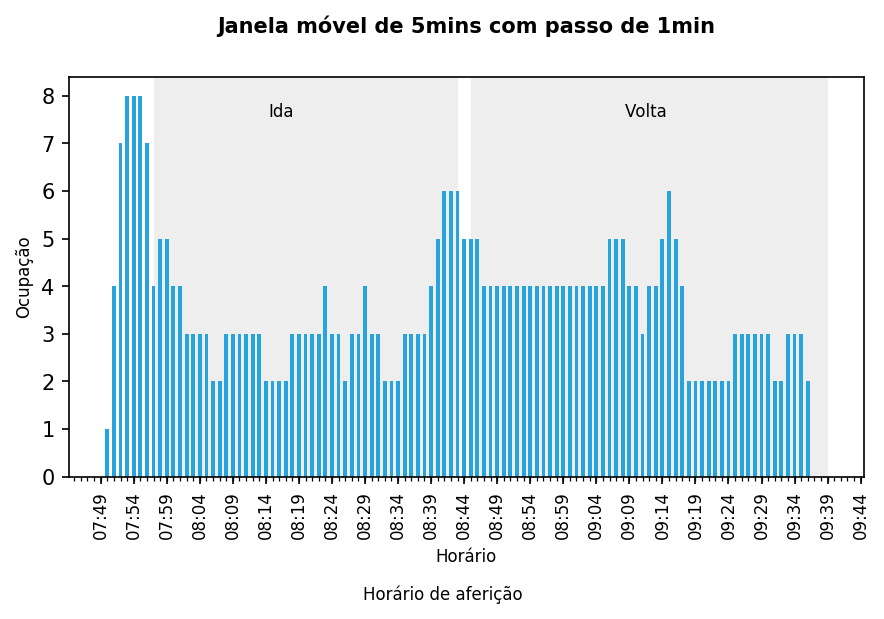

In [511]:
date = "07/12/2017"

# Get the start/end timestamps for the round trip
a = trips.filter((col("date") == date) & (col("direction") == 0)).select("start", "end").first()
b = trips.filter((col("date") == date) & (col("direction") == 1)).select("start", "end").first()

r = occupation.filter(col("date") == date).cache().toPandas()
r = r.set_index(r["window"].map(lambda x: x[0]))

x = np.arange(len(r))

fig, ax = plt.subplots(dpi=150, figsize=(6, 4))

# Draw the first trip area
fig.text(0.5, -0.02, "Horário de aferição", horizontalalignment='center', **text_kwargs)
asi = r.index.get_loc(a['start'], method='nearest') 
aei = r.index.get_loc(a['end'], method='nearest')
ax.annotate("Ida", xy=(0.25, 0.9), xycoords='axes fraction', **text_kwargs)
ax.axvspan(r.iloc[asi]['window'][0], r.iloc[aei]['window'][1], **span_kwargs)

# Draw the first trip area
bsi = r.index.get_loc(b['start'], method='nearest')
bei = r.index.get_loc(b['end'], method='nearest')
ax.annotate("Volta", xy=(0.70, 0.9), xycoords='axes fraction', **text_kwargs)
ax.axvspan(r.iloc[bsi]['window'][0], r.iloc[bei]['window'][1], **span_kwargs)

# Draw the occupation
ax.bar(r.index, r['occupation'], width=0.0004, color=wifi_color)

# Prepare the graph
ax.set_title("Janela móvel de 5mins com passo de 1min", **title_kwargs)
ax.set_ylabel("Ocupação", **text_kwargs)
ax.set_xlabel("Horário", **text_kwargs)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xticks(**labels_kwargs)
plt.tight_layout()

In [313]:
%%javascript
// Disable output scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

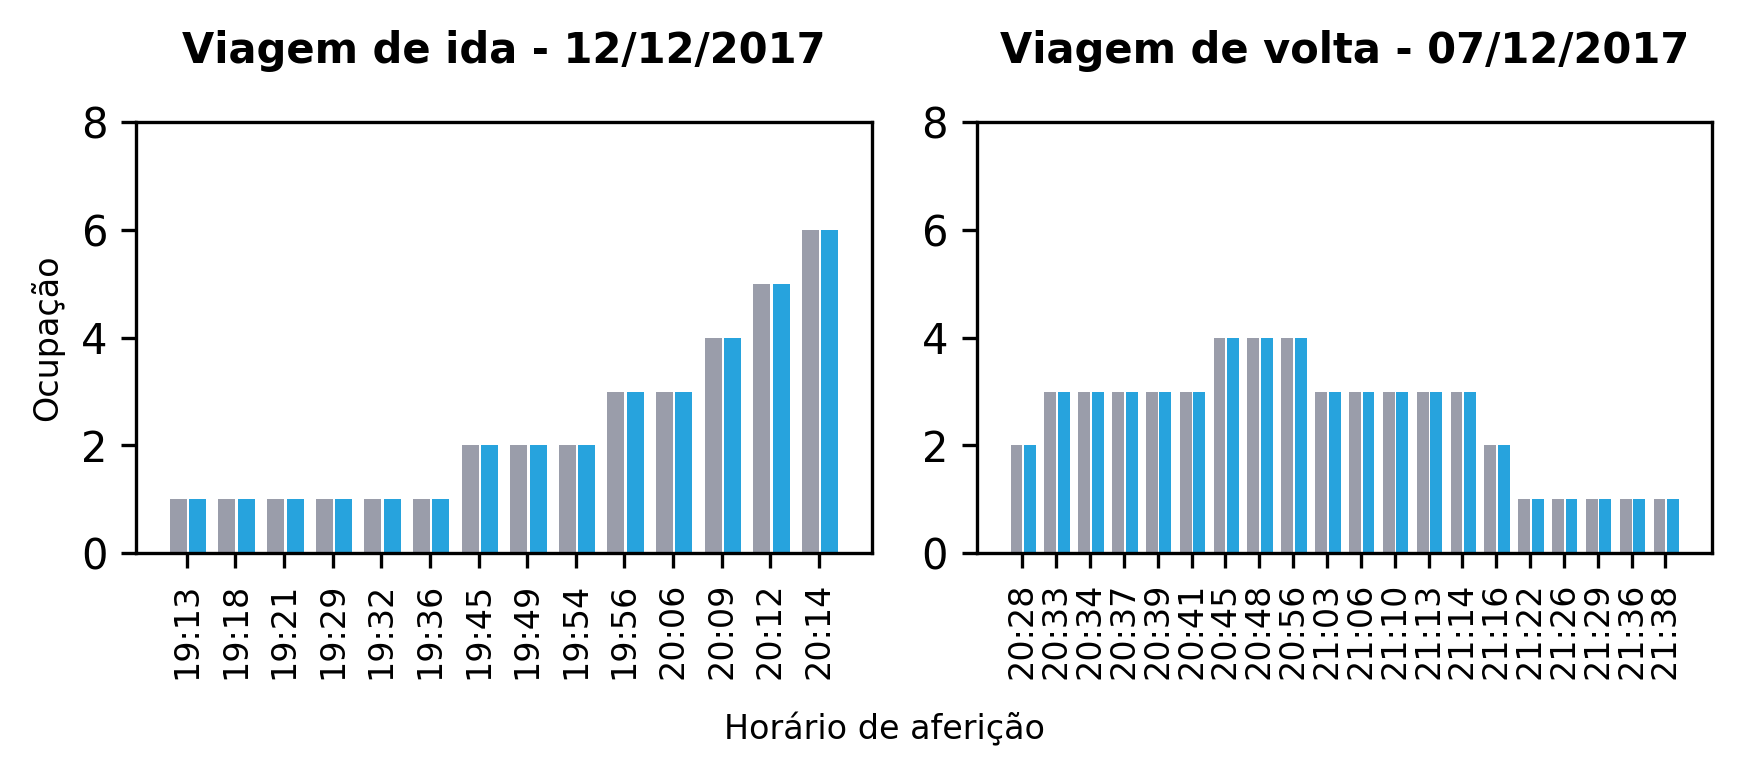

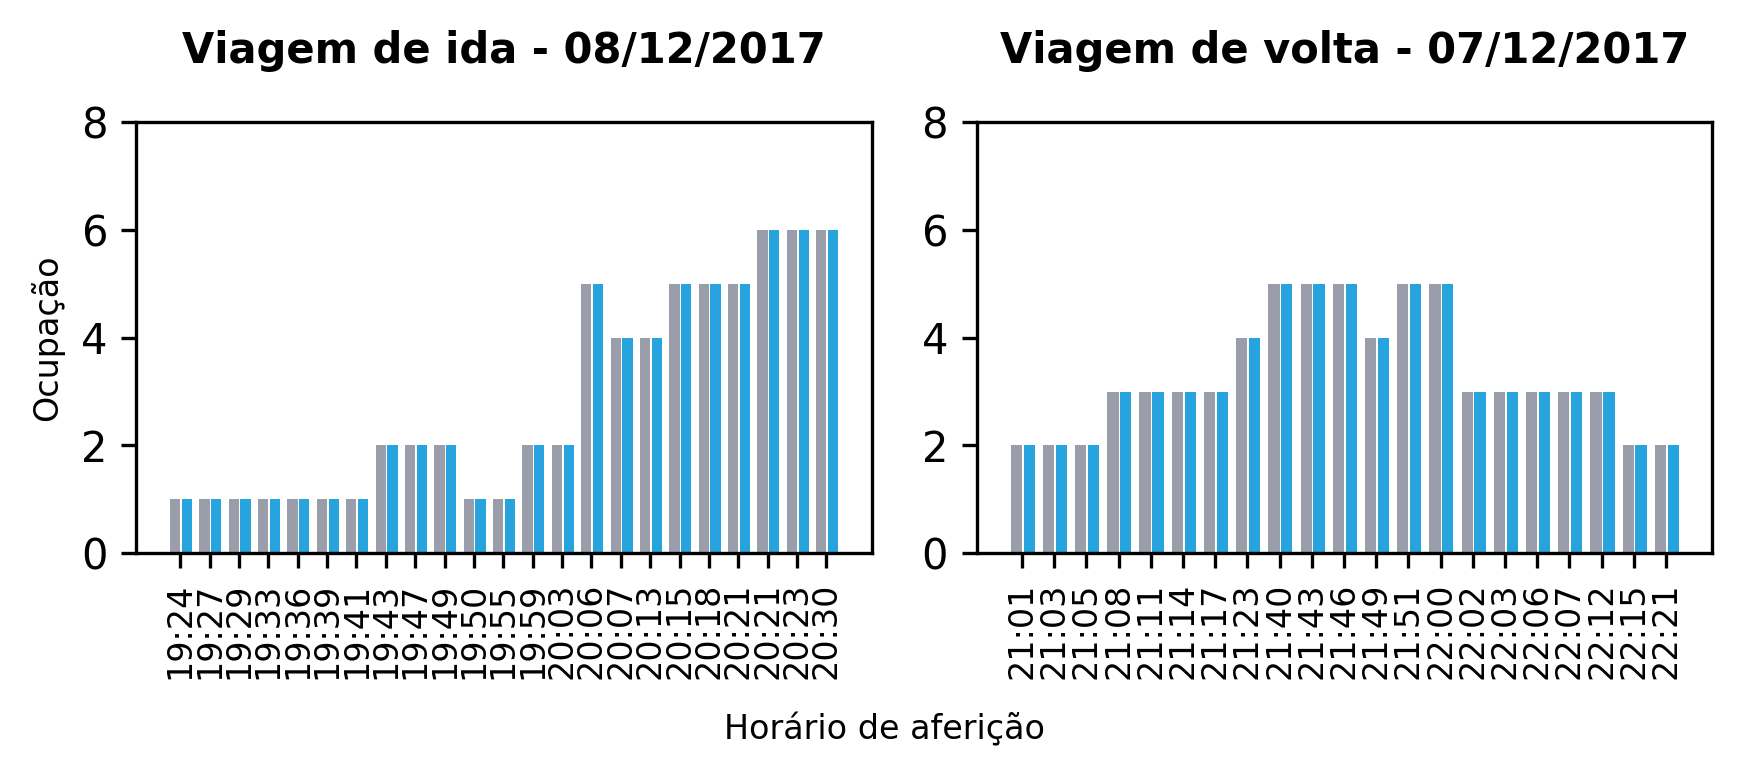

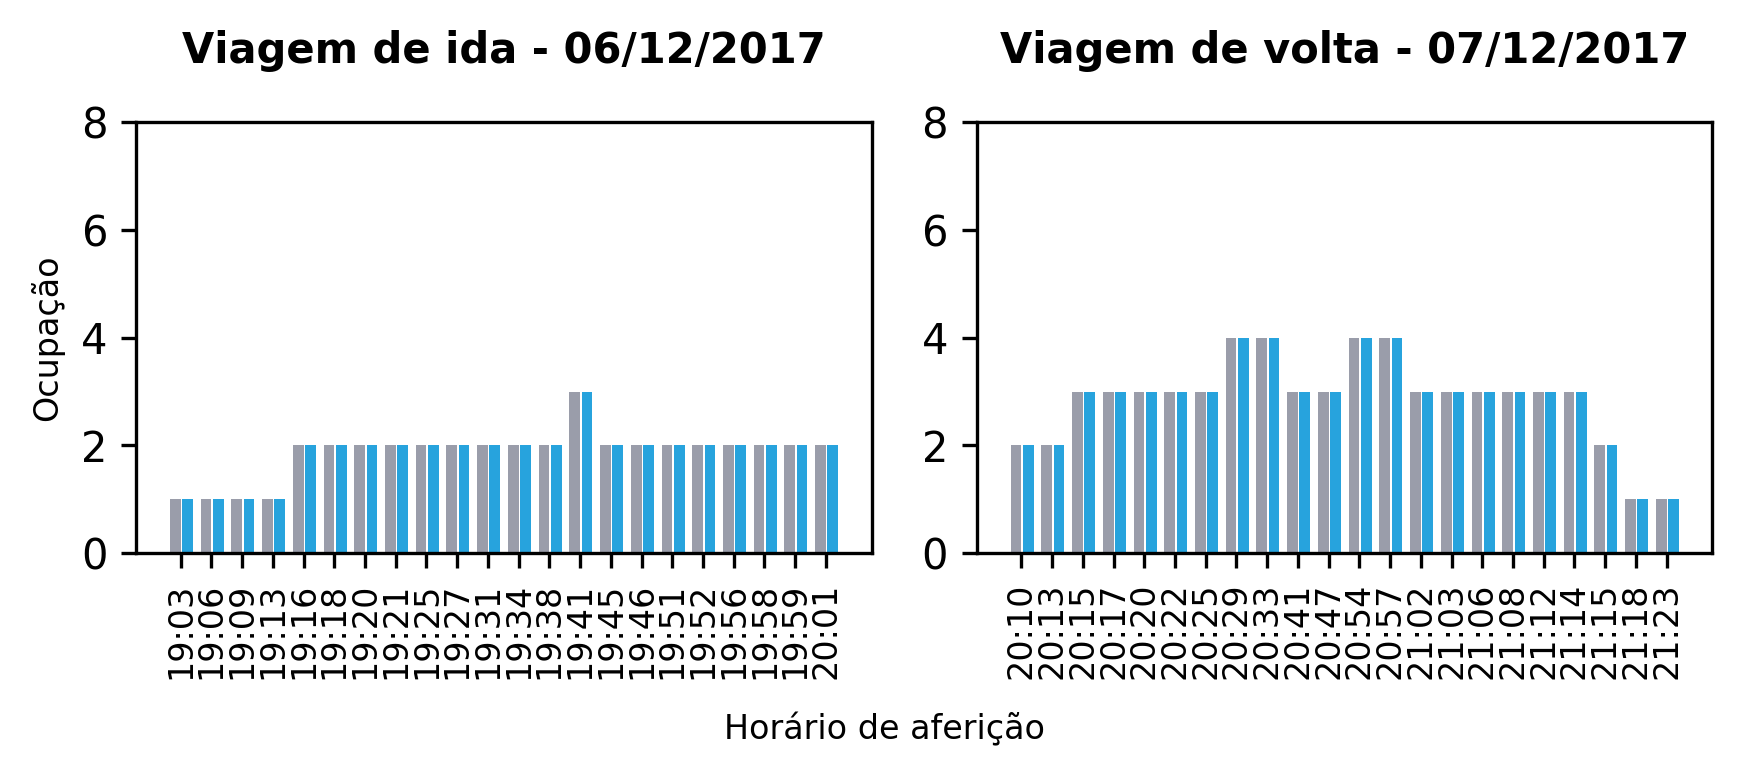

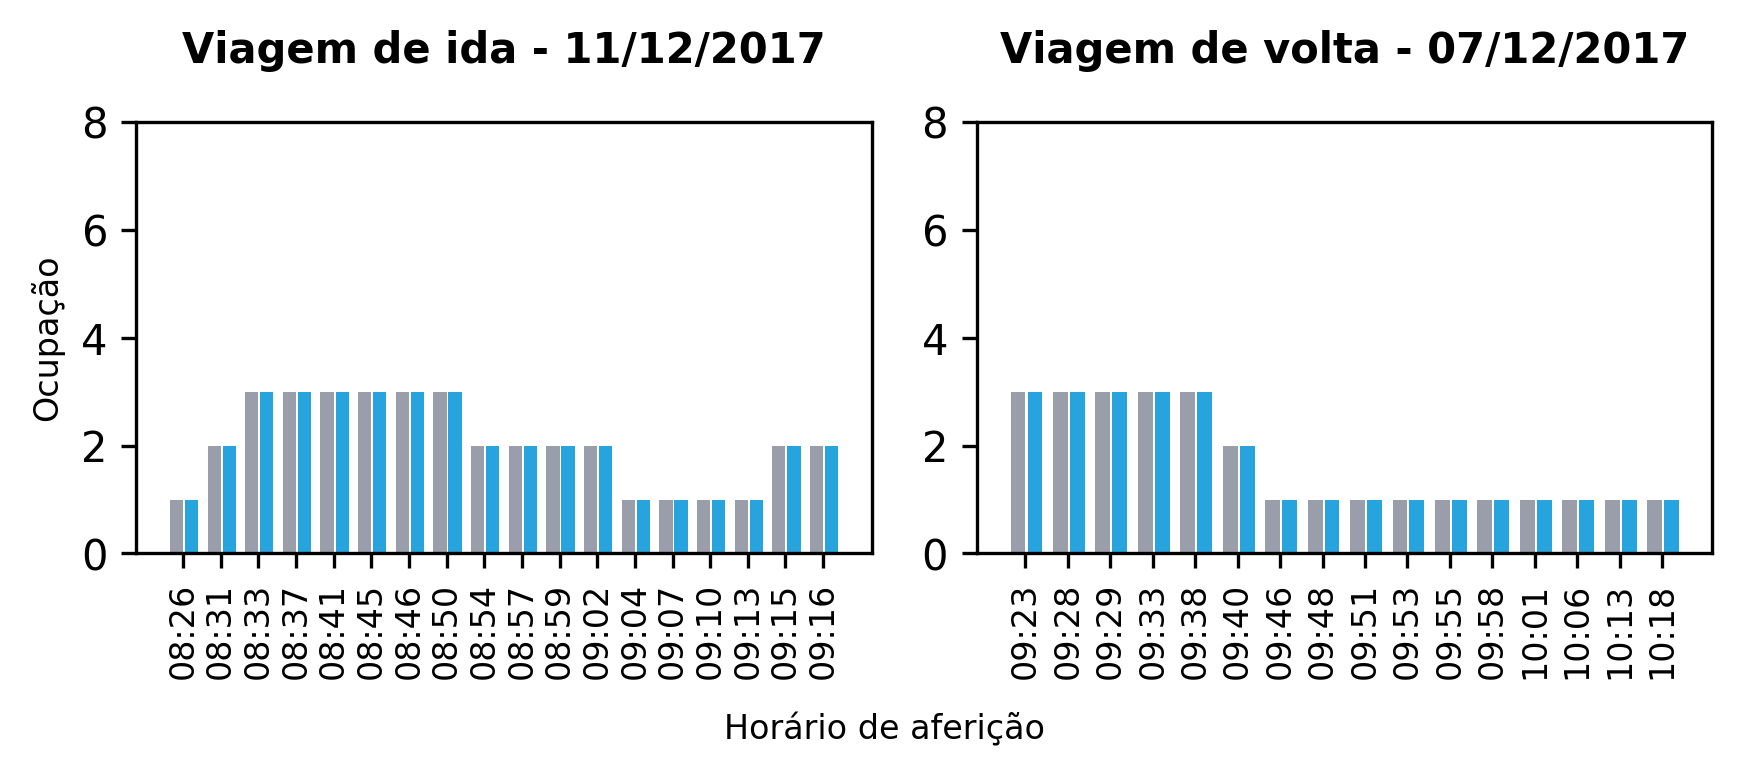

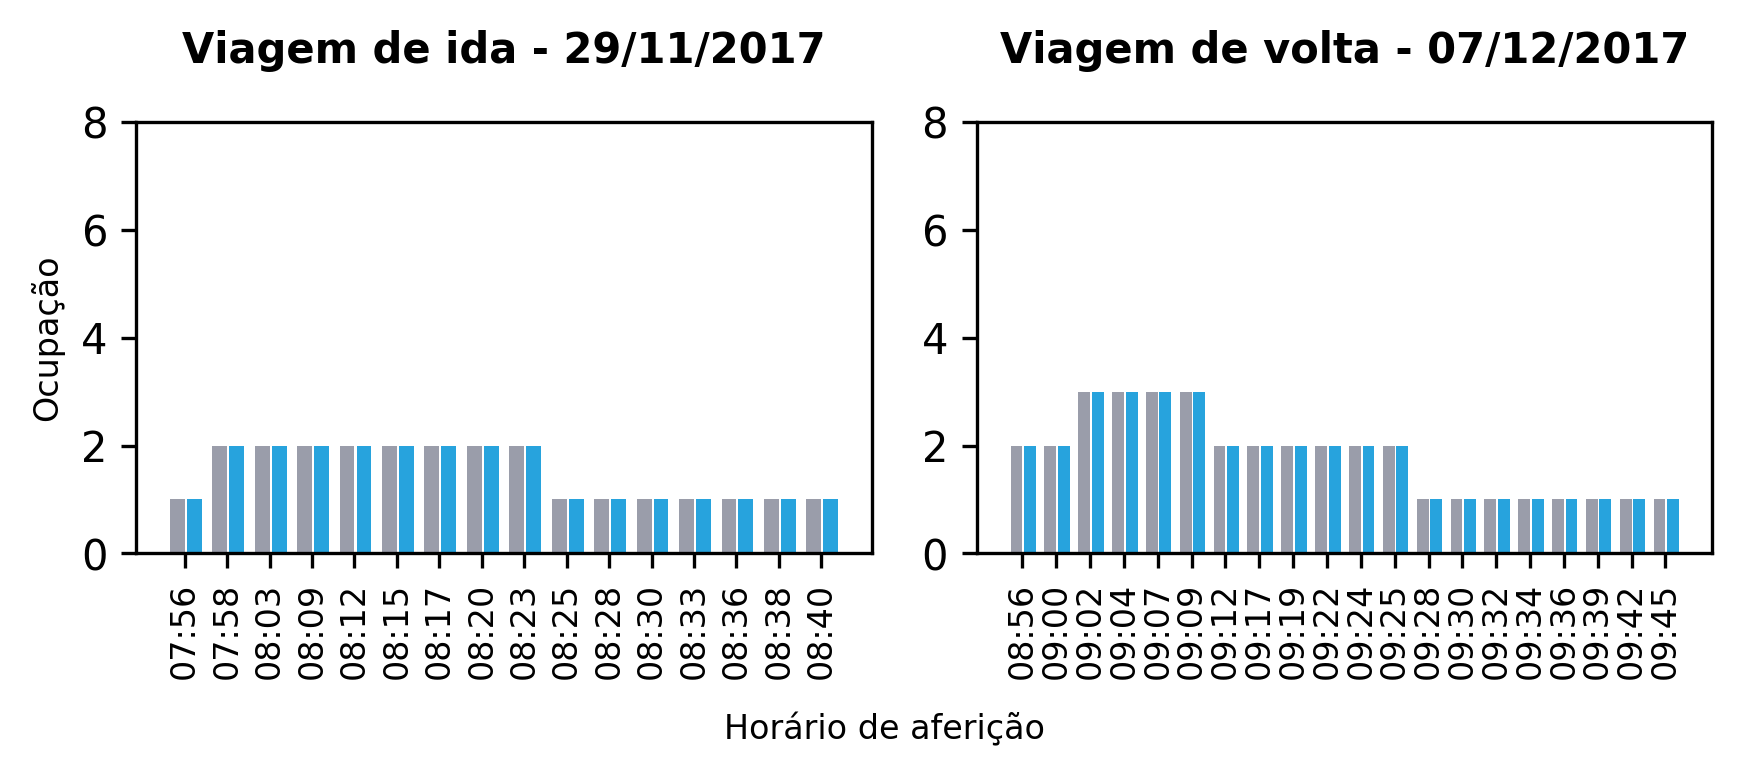

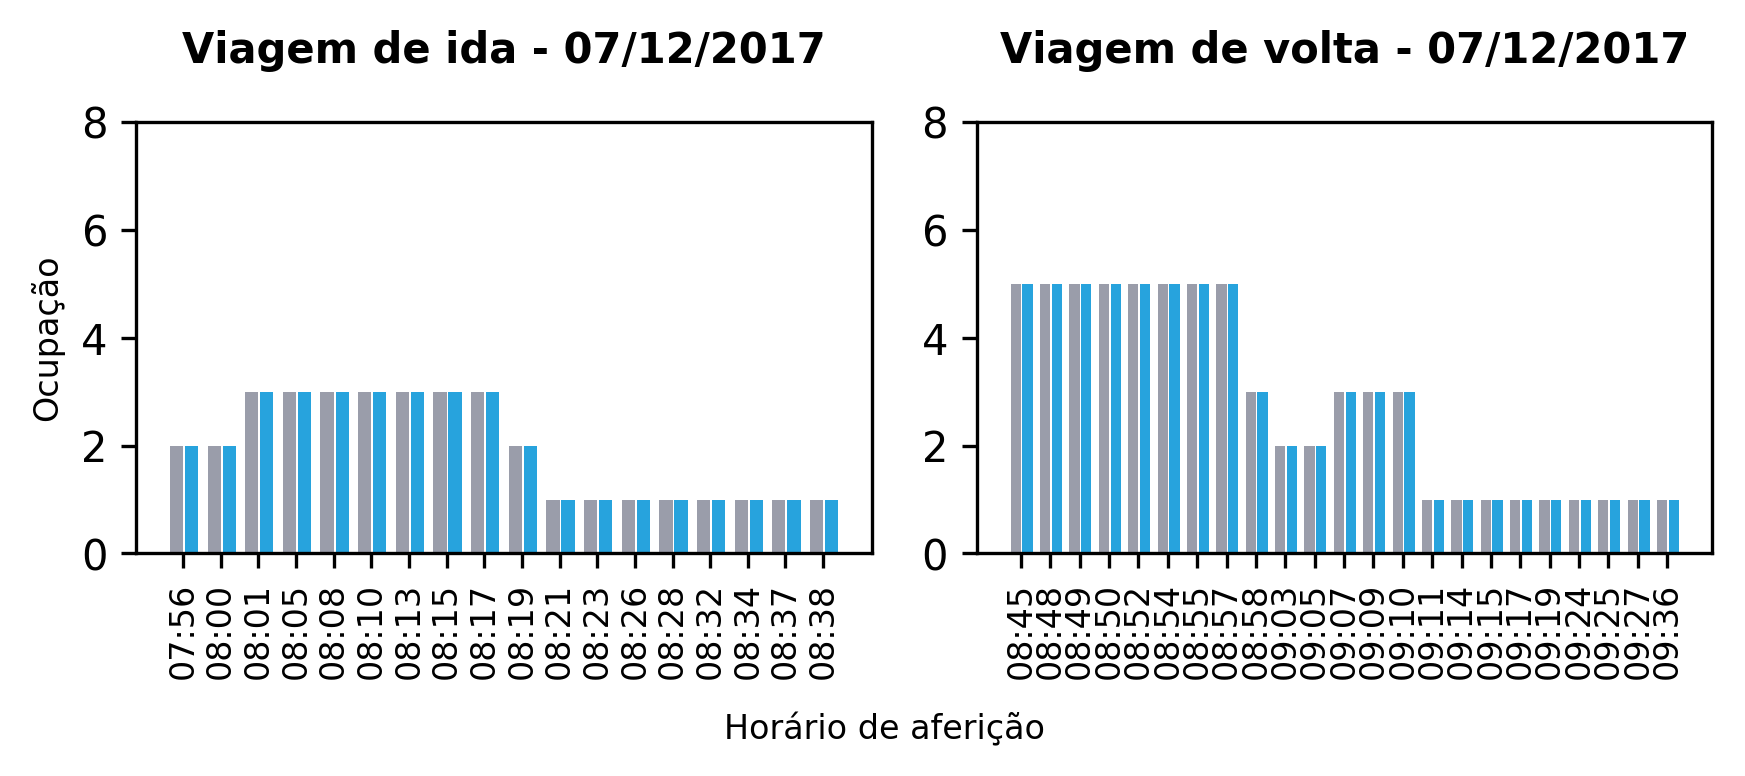

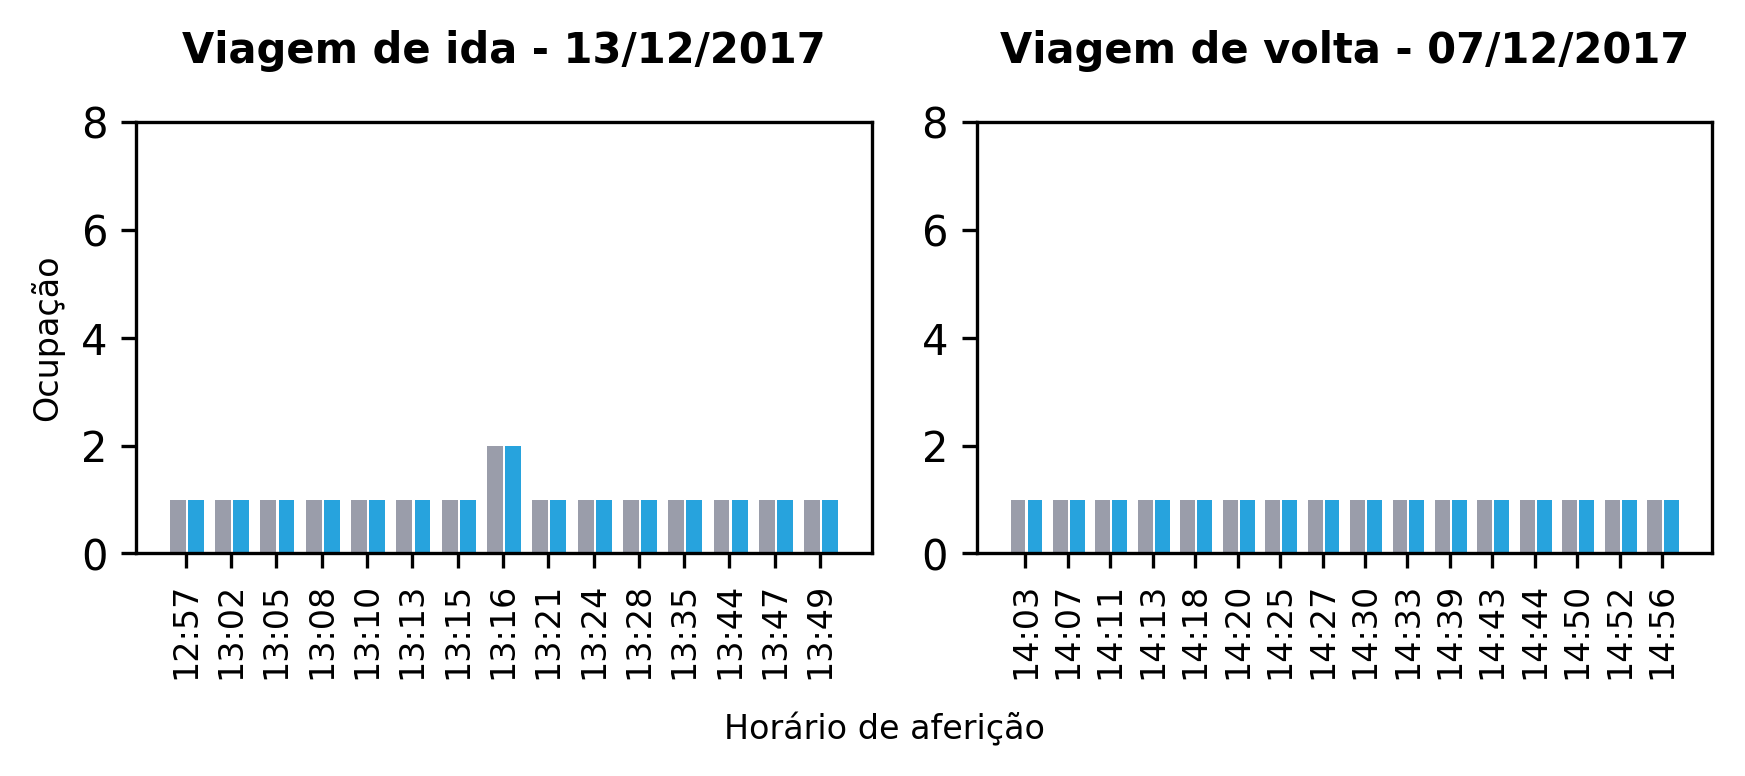

In [542]:
dates = map(lambda x: x[0], survey.select(date_format("date", "dd/MM/yyyy")).distinct().toPandas().values.tolist())
# date = "07/12/2017" 

for date in dates:
    data = (
        survey
        .filter((date_format("date", "dd/MM/yyyy") == date) & (col("occupation") != 8))
        .orderBy("timestamp")
    )

    fig, ax = plt.subplots(nrows=1, ncols=2, dpi=300, figsize=(6, 2.5))
    axes = ax.flatten()

    # Get the start/end timestamps for the round trip
    s = trips.filter((col("date") == date) & (col("direction") == 0)).select(col("end").alias("timestamp")).first()
    e = trips.filter((col("date") == date) & (col("direction") == 1)).select(col("start").alias("timestamp")).first()

    # Get first and second ride values
    a = data.filter(col("timestamp") <= s["timestamp"].strftime("%Y-%m-%d %T")).toPandas().set_index("timestamp")
    b = data.filter(col("timestamp") >= e["timestamp"].strftime("%Y-%m-%d %T")).toPandas().set_index("timestamp")

    xA = np.arange(len(a))
    xB = np.arange(len(b))

    w = 0.35 # bar width
    s = 0.05 # bar spacing

    axes[0].set_title("Viagem de ida - %s" % date, **title_kwargs)
    axes[0].bar(xA - w / 2, a.occupation.values, width=w, color=real_color)
    axes[0].bar(xA + w / 2 + s, a.occupation.values, width=w, color=wifi_color)
    axes[0].axes.set_ylabel("Ocupação", **text_kwargs)
    axes[0].axes.set_ybound(0, 8)
    axes[0].axes.set_xticks(xA)
    axes[0].axes.set_xticklabels(a.index.map(lambda x: x.strftime("%H:%M")), **labels_kwargs)

    axes[1].set_title("Viagem de volta - %s" % "07/12/2017", **title_kwargs)
    axes[1].bar(xB - w / 2, b.occupation, width=w, color=real_color)
    axes[1].bar(xB + w / 2 + s, b.occupation.values, width=w, color=wifi_color)
    axes[1].axes.set_ybound(0, 8)
    axes[1].axes.set_xticks(xB)
    axes[1].axes.set_xticklabels(b.index.map(lambda x: x.strftime("%H:%M")), **labels_kwargs)

    fig.text(0.5, -0.02, "Horário de aferição", horizontalalignment='center', **text_kwargs)
    fig.tight_layout()

plt.show()